In [2]:
import torch
from torch import nn
import torchvision 
from torchvision import datasets
import torchinfo
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
!git clone https://github.com/stanleyedward/pytorch_modules.git

fatal: destination path 'pytorch_modules' already exists and is not an empty directory.


In [53]:
def create_vitb16_model(num_classes:int=101, 
                          seed:int=42):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head. 
            Defaults to 3.
        seed (int, optional): random seed value. Defaults to 42.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model. 
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head with random seed for reproducibility
    torch.manual_seed(seed)
    model.heads = nn.Sequential(
        nn.Linear(in_features=768, out_features=num_classes),
    )
    
    return model, transforms
vit, vit_transforms = create_vitb16_model()

In [54]:
vit

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [55]:
from torchinfo import summary
summary(vit, 
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 101]             768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

In [56]:
train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    vit_transforms
])
train_transforms

Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)
)

In [46]:
from pathlib import Path
data_dir = Path("data")

train_data = datasets.Food101(root=data_dir,
                              split='train',
                              transform=train_transforms,
                              download=True)
test_data = datasets.Food101(root=data_dir,
                             split='test',
                             transform=vit_transforms,
                             download=True)

In [57]:
import os 
from torch.utils.data import DataLoader
BATCH_SIZE = 16
NUM_WORKERS = os.cpu_count()

train_dataloader = torch.utils.data.DataLoader(train_data,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_data,
                                              batch_size=8,
                                              shuffle=True,
                                              num_workers=NUM_WORKERS)
len(train_dataloader), len(test_dataloader)

(4735, 3157)

In [58]:
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=0.0003)
loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer)
lr_scheduler

In [ ]:
from pytorch_modules.modules import train_engine

In [60]:

vit_results = train_engine.train(model=vit,
                                train_dataloader=train_dataloader,
                                test_dataloader=test_dataloader,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                epochs=4,
                                device=device,
                                lr_scheduler=lr_scheduler)

  0%|          | 0/4 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/4735 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/3157 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.5111 | train_acc: 0.5248 | test_loss: 1.8408 | test_acc: 0.7071 | train_epoch_time: 497.3805 | test_epoch_time: 169.5461


Training Epoch 1:   0%|          | 0/4735 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/3157 [00:00<?, ?it/s]

Epoch: 2 | train_loss: 2.0948 | train_acc: 0.6340 | test_loss: 1.7366 | test_acc: 0.7388 | train_epoch_time: 496.2584 | test_epoch_time: 169.3527


Training Epoch 2:   0%|          | 0/4735 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/3157 [00:00<?, ?it/s]

Epoch: 3 | train_loss: 2.0022 | train_acc: 0.6630 | test_loss: 1.6892 | test_acc: 0.7534 | train_epoch_time: 497.4696 | test_epoch_time: 170.1765


Training Epoch 3:   0%|          | 0/4735 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/3157 [00:00<?, ?it/s]

Epoch: 4 | train_loss: 1.9514 | train_acc: 0.6791 | test_loss: 1.6648 | test_acc: 0.7595 | train_epoch_time: 497.8695 | test_epoch_time: 170.1929


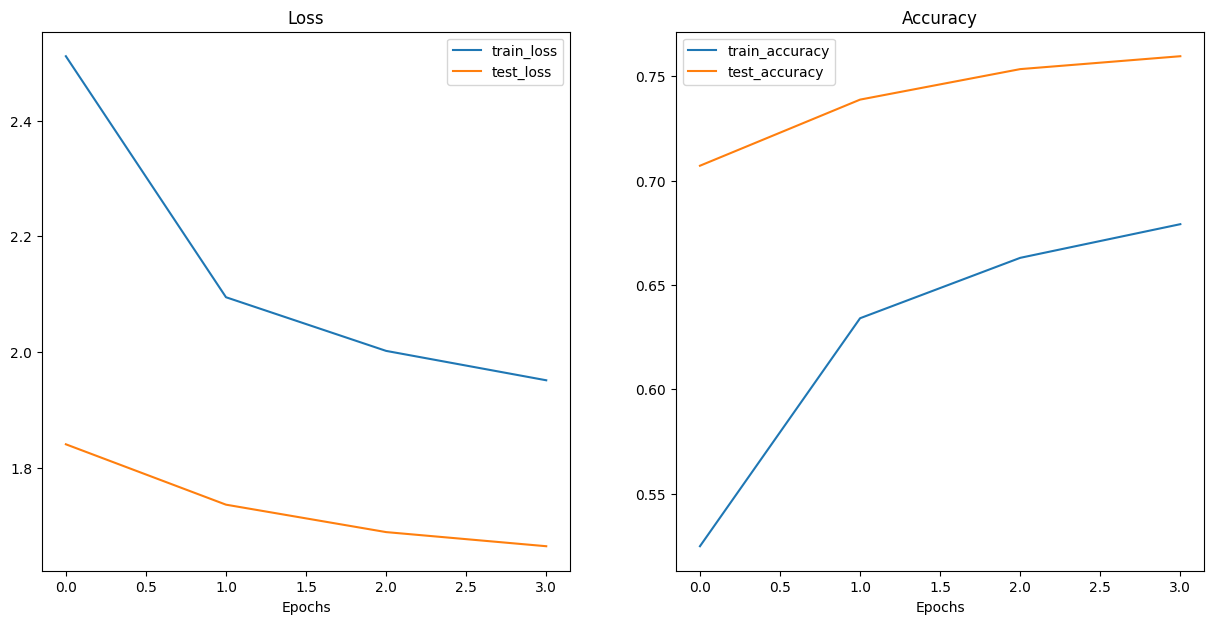

In [61]:
from pytorch_modules.modules import utils
utils.plot_loss_curves(vit_results)

In [62]:
from pytorch_modules.modules import utils
utils.save_model(model=vit,
        target_dir="models",
          model_name="vitb16_food101_4epochs.pt")

[INFO] Saving model to: models/vitb16_food101_4epochs.pt


In [64]:
from pathlib import Path
vit_model_size = Path('models/vitb16_food101_4epochs.pt').stat().st_size // (1024**2)
print(f"ViT model size: {vit_model_size} MB")

ViT model size: 327 MB
